## Power Problem

### Epsilon Greedy

In [1]:
#export
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#export
class PowerSocket:
    def __init__(self, q):                
        self.q = q   # the true reward value                
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried
    
    # the reward is a random distribution around the initial mean value set for this socket
    def charge(self):
        # a guassian distribution with unit variance around the true value 'q'
        return np.random.randn() + self.q
    
    # increase the number of times this socket has been used and improve the estimate of the 
    # value (the mean) by combining the new reward 'r' with the current mean
    def update(self,R):
        self.n += 1
        # the new estimate is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

In [3]:
num_sockets = 5

def socket_test(total_steps,eps):
    
    # create the specified number of sockets with unique random mean values from 1 to the number of sockets
    sockets = [PowerSocket(q) for q in random.sample(range(1,1+num_sockets), num_sockets)]

    # save data about the run to create graphs
    rewards = np.empty(total_steps)

    # loop for the chosen number of time-steps
    for t in range(total_steps):

        # probability of pulling a bandit at random
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < eps:
            index = np.random.choice(num_sockets)
        else:
            # choose the socket with the current highest mean reward
            index = np.argmax([socket.Q for socket in sockets])

        # charge from the chosen socket and update its estimated reward value
        reward = sockets[index].charge()
        sockets[index].update(reward)

        # store the reward from this time-step
        rewards[t] = reward

    return rewards    

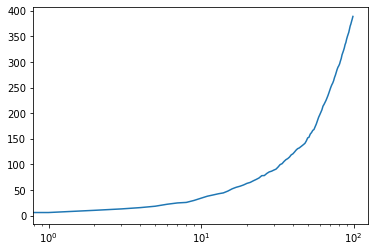

In [4]:
total_steps = 100

rewards = socket_test(total_steps,0.1)
cumulative_average = np.cumsum(rewards) / (np.arange(total_steps)+1) 


# plot total reward
plt.plot(np.cumsum(rewards))
plt.xscale('log')
plt.show()

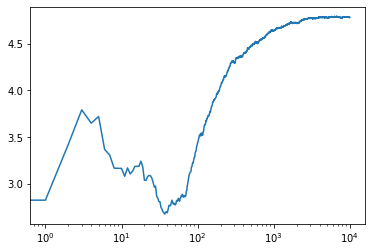

In [5]:
total_steps = 10000

rewards = socket_test(total_steps,0.1)
cumulative_average = np.cumsum(rewards) / (np.arange(total_steps)+1) 

# plot moving average
plt.plot(cumulative_average)
plt.xscale('log')
plt.show()

# for b in bandits:
#     print( b.mean )

# print(f'final cumulative reward = {cumulative_average[N-1]}')